In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from scipy.signal import find_peaks

from pygama.flow import DataLoader
from pygama.flow import FileDB
from pygama.lgdo import Array
from pygama.math import histogram as pgh

In [ ]:
fdb = FileDB(config="../processing/metadata/dataloader_configs/cage_filedb_config.json", scan=True)
fdb.to_disk("../processing/cage_filedb.lh5", "o")

In [3]:
fdb = FileDB("../processing/cage_filedb.lh5")

In [4]:
dl = DataLoader(config="../processing/metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

In [5]:
def get_timestamps(data):
    if 'timestamp' not in data.keys():
        return np.sum([get_runtime(data[key]) for key in data.keys()])
    # correct for timestamp rollover
    clock = 100e6 # 100 MHz
    UINT_MAX = 4294967295 # (0xffffffff)
    t_max = UINT_MAX / clock


    ts = data['timestamp'].nda / clock # converts to float

    tdiff = np.diff(ts)
    tdiff = np.insert(tdiff, 0 , 0)
    iwrap = np.where(tdiff < 0)
    iloop = np.append(iwrap[0], len(ts))

    ts_new, t_roll = [], 0
    for i, idx in enumerate(iloop):
        ilo = 0 if i==0 else iwrap[0][i-1]
        ihi = idx
        ts_block = ts[ilo:ihi]
        t_last = ts[ilo-1]
        t_diff = t_max - t_last
        ts_new.append(ts_block + t_roll)
        t_roll += t_last + t_diff
    ts_corr = np.concatenate(ts_new)

    return ts_corr/60 # minutes

def calibrate_energy(energy, ebins):
    hist, _ = np.histogram(energy, ebins)
    third = int(len(ebins)/3)
    k40_peak = ebins[np.argmax(hist[third:]) + third]
    return energy*1460.8/k40_peak



ebins = np.linspace(0, 6000, 1000)
cal_ebins = np.linspace(0, 4000, 2000)
dcr_bins = np.arange(-75, 75)

In [6]:
dl.reset()
dl.set_files(f"run in [433, 434, 435, 436, 437]")
dl.set_output(merge_files=False, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp"])
bkg = dl.load()

Loading data: 100%|██████████| 83/83 [01:16<00:00,  1.09 keys/s, key=3289] 


In [7]:
ts = None
energy = None
breaks = []
for file in bkg.keys():
    if ts is None:
        ts = get_timestamps(bkg[file])
    else:
        ts = np.append(ts, [ts[-1] + t for t in get_timestamps(bkg[file])])
        
    if energy is None:
        energy = bkg[file]['trapEmax_ctc'].nda
    else:
        energy = np.append(energy, bkg[file]['trapEmax_ctc'].nda)
    if fdb.df.iloc[file]['cycle'] in [3257, 3265, 3273, 3281]:
        breaks += [ts[-1]]



(3000.0, 3500.0)

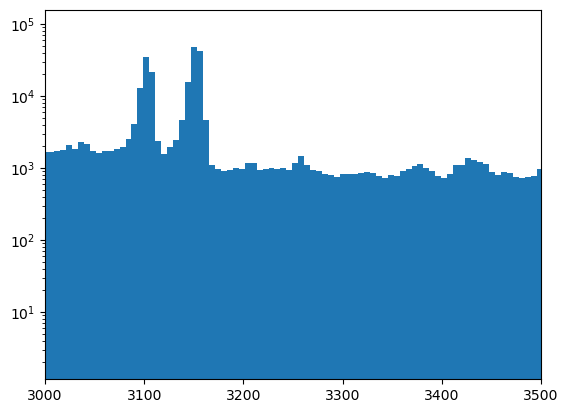

In [8]:
plt.hist(energy, bins=ebins)
plt.yscale('log')
plt.xlim(3000, 3500)

Text(0.5, 1.0, 'ICPC stability study - Runs 433-437')

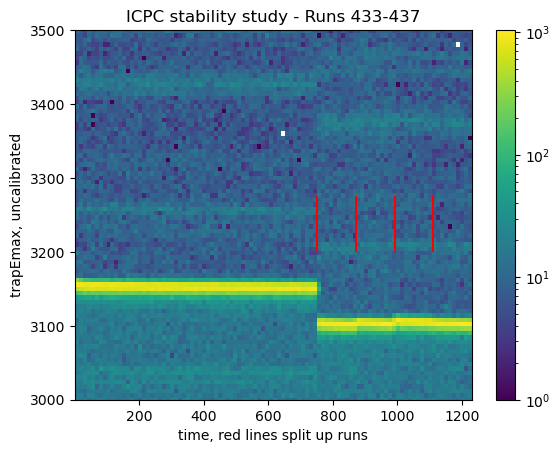

In [15]:
plt.hist2d(ts, energy, 
           bins=(100, ebins),
           range=[None, [3000, 3500]],
           norm = colors.LogNorm())
plt.ylim(3000, 3500)
plt.vlines(breaks, 3200, 3275, color='r')
#for b in breaks:
#    plt.axvline(b, color='r', alpha=0.5)
plt.colorbar()
plt.ylabel("trapEmax, uncalibrated")
plt.xlabel("time, red lines split up runs")
plt.title("ICPC stability study - Runs 433-437")

In [ ]:
bkg_hist = np.histogram2d(ts, energy, 
           bins=(100, ebins))
np.median(bkg_hist[])

In [10]:
dl.reset()
dl.set_files(f"run in [450, 451, 452, 453, 454, 455, 456]")
dl.set_output(merge_files=False, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp"])
data = dl.load()

Loading data: 100%|██████████| 111/111 [01:28<00:00,  1.25 keys/s, key=3656]


In [11]:
ts_data = None
energy_data = None
breaks_data = []
for file in data.keys():    
    if ts_data is None:
        ts_data = get_timestamps(data[file])
    else:
        ts_data = np.append(ts_data, [ts_data[-1] + t for t in get_timestamps(data[file])])
        
    if energy_data is None:
        energy_data = data[file]['trapEmax_ctc'].nda
    else:
        energy_data = np.append(energy_data, data[file]['trapEmax_ctc'].nda)

    if fdb.df.iloc[file]['cycle'] in [3555, 3566, 3579, 3589, 3640, 3648]:
        breaks_data += [ts_data[-1]]

Text(0.5, 1.0, 'Stable ICPC - Run 450-456')

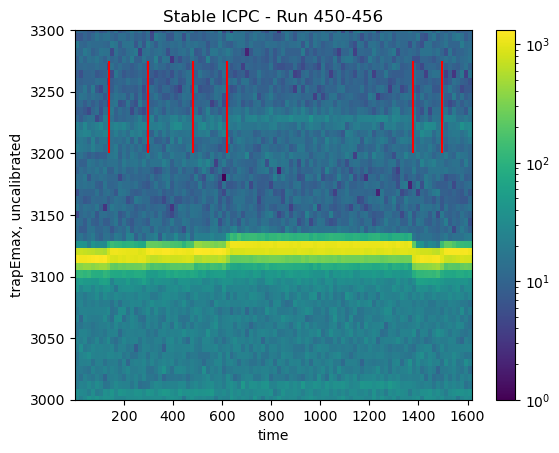

In [12]:
plt.hist2d(ts_data, energy_data, 
           bins=(100, ebins),
           range=[None, [3100, 3300]],
           norm = colors.LogNorm())
plt.ylim(3000, 3300)
plt.vlines(breaks_data, 3200, 3275, color='r')
#plt.vlines(breaks, 3200, 3275, color='r')
#for b in breaks:
#    plt.axvline(b, color='r', alpha=0.5)
plt.colorbar()
plt.ylabel("trapEmax, uncalibrated")
plt.xlabel("time")
plt.title("Stable ICPC - Run 450-456")

(3000.0, 3500.0)

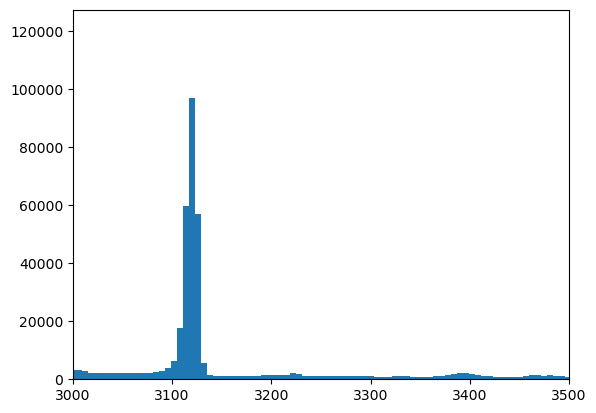

In [14]:
plt.hist(energy_data, bins=ebins)
plt.xlim(3000, 3500)

In [16]:
dl.reset()
dl.set_files(f"run in [444, 445, 446, 447, 448]")
dl.set_output(merge_files=False, columns=["trapEmax_ctc", "dcr", "ToE", "timestamp"])
data = dl.load()

Loading data: 100%|██████████| 83/83 [01:08<00:00,  1.21 keys/s, key=3491] 


In [17]:
ts_bias = None
energy_bias = None
breaks_bias = []
for file in data.keys():    
    if ts_bias is None:
        ts_bias = get_timestamps(data[file])
    else:
        ts_bias = np.append(ts_bias, [ts_bias[-1] + t for t in get_timestamps(data[file])])
        
    if energy_bias is None:
        energy_bias = data[file]['trapEmax_ctc'].nda
    else:
        energy_bias = np.append(energy_bias, data[file]['trapEmax_ctc'].nda)

    if fdb.df.iloc[file]['cycle'] in [3453, 3462, 3471, 3482]:
        breaks_bias += [ts_bias[-1]]

Text(0.5, 1.0, 'After Bias Down - Run 444-448')

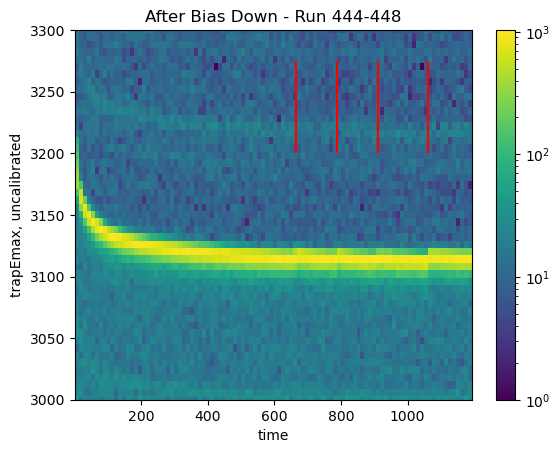

In [20]:
plt.hist2d(ts_bias, energy_bias, 
           bins=(100, ebins),
           range=[None, [3100, 3300]],
           norm = colors.LogNorm())
plt.ylim(3000, 3300)
plt.vlines(breaks_bias, 3200, 3275, color='r')
#plt.vlines(breaks, 3200, 3275, color='r')
#for b in breaks:
#    plt.axvline(b, color='r', alpha=0.5)
plt.colorbar()
plt.ylabel("trapEmax, uncalibrated")
plt.xlabel("time")
plt.title("After Bias Down - Run 444-448")

(3000.0, 3500.0)

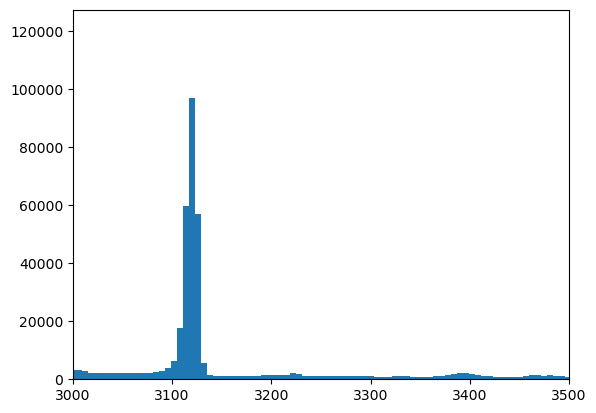

In [14]:
plt.hist(energy_bias, bins=ebins)
plt.xlim(3000, 3500)